# Isfjell gjenkjenning
Målet med denne modellen er at den skal kunne ta inn satelittbilder av gjenstander i havet å si om det er et isfjell eller ikke. Disse ofte er det snakk om skip

### Imports

In [1]:
import pandas as pd
import json
import numpy as np
from fastai.vision.all import *
from fastai.metrics import RocAucBinary

Denne modellen ble laget i Google Colab. Den git mulighet for å koble selg opp til Google Drive som lagringsplass. For å gjøre dette, må denne koden lagges til.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Henting av data
I denne oppgaven har oppgave har vi brukt et datasett som stammer fra [Statoil Iceberg Challange](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge). Dataen er i utgangspunktet komprimert. Dette er fikset i en annen notebook.

Starter med å utforske dataen

In [3]:
train = pd.read_json(r"/content/drive/MyDrive/Iceberg challenge/train.json")

In [4]:
train.head(2)

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -29.537971, -29.092485, -32.834259, -32.190609, -29.538139, -28.668869, -29.092695, -26.813871, -26.813911, -28.264969, -25.571039, -26.170347, -25.571125, -28.265137, -28.265181, -26.170513, -28.669331, -24.232399, -25.571377, -30.504866, -31.031487, -29.538857, -27.879414, -26.814545, -24.484478, -25.571672, -28.265686, -29.539068, -28.669796, -27.509998, -31.031866, -31.03191, -31.03195, -29.53932, -29.53936, -34.286621, -28.670132, -25.866602, -27.510378, -26.171484, -26.487411, -30.009279, -31.032372, -26.487539, -29.539783, -31.032497, -29...","[-27.154118, -29.537888, -31.0306, -32.190483, -32.834217, -31.030729, -31.030769, -32.834343, -28.668869, -27.154495, -29.538267, -30.5044, -30.504444, -32.190903, -35.113506, -34.285694, -36.02874, -31.031235, -31.031275, -29.093117, -29.538689, -31.031401, -28.26539, -27.509661, -28.669544, -30.504992, -31.031612, -29.093454, -28.265644, -29.09354, -28.265686, -29.09358, -30.008774, -32.835396, -31.592484, -33.530724, -34.286537, -32.835567, -32.191917, -33.530891, -30.505581, -32.192043, -32.192085, -31.592863, -31.03233, -31.032372, -32.192253, -28.266401, -27.880341, -30.009489, -31....",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, -12.666336, -10.387527, -11.345262, -13.046976, -13.720695, -12.728892, -12.791664, -15.589305, -15.853929, -18.204786, -15.503053, -13.047442, -13.047501, -12.243308, -12.184479, -12.60539, -11.727338, -9.700563, -12.605564, -16.035534, -13.791961, -10.581721, -7.666193, -8.702394, -12.483576, -13.934649, -13.311546, -14.841942, -16.90056, -18.565422, -18.565422, -16.800262, -13.514631, -11.728271, -8.624724, -7.986655, -10.98196, -18.56583, -20.627296, -20.174074, -16.036699, -13.312364, -16.800902999999998, -18.566181, -15.94598, -14.302303,...","[-31.506321, -27.984554, -26.645678, -23.767605, -22.146997, -27.289545, -25.761837, -25.761894, -26.961914, -26.646084, -25.219025, -24.959785, -25.762188, -25.762245, -24.959961, -26.646435, -25.486656, -23.994041, -23.994101, -26.341869, -28.355331, -26.646786, -24.463955, -25.219784, -25.762886, -23.125195, -22.148281, -25.487297, -25.220078, -25.487413, -25.763237, -22.335375, -22.721535, -22.721535, -25.220367, -27.986481, -26.048338, -26.048397, -28.356323, -33.312069, -29.146612, -26.647894, -25.763878, -27.632372, -32.668671, -25.488289, -22.722294, -21.440002, -21.44006, -25.4885...",38.1562,0


Vi ser at dataen består av to tre forskjellige kolonner. Den første er en ID.

De to neste er to band. Dette er en liste med tall og reptesenterer bildene. Det er en Bildene er 75 x 75. Disse er ikke normale bilder men radarmålinger. Disse er målt i Db og kan derfor være negative. De to forskjellige bildne er forskjellige polariteter. Altså en er målt vertikal og en er målt horonsentalt.

Den neste er vinkelen den måles på og den siste er 0 eller 1 alt ettersom det er et isfjell eller ei.

## Datablock
For at en skal kunne trene en modell med fastai, trenger vi en Datablock. Vi ønsker å bruke en forhondstrent. Modellen vi ønsker å bruke er en klassifiserings modell (isfjell eller ikke isfjell) som tar inn et bilde.

### Bilder
Ettersom dataen som modellen skal ta inn består av to bilder og et tall (en vinkel) så er det mulig å gjøre dette om til et bilde. 

Vi starter med å se på bildene. Disse er som nevnt ikke normale bilder, men radarmålinger målt i Db. Første oppgave er å gjøre dem fra tekst til normale bilder. Først ser vi hva som er maks og min verdi til de bildene slik at de kan gjøres om til normale verdier. Disse er fundet i den tidligere notebooken.

Fordi bildene er svart hvit, kan vi gjøre dem om til rød og grønn fargen i bildet.

Vinkelen gjøres vi også gjøre om til en blåfarge. Denne kan dermed brukes som en kontekst.

Vi lager en funskjon som returnerer et bildet med disse verdiene

In [5]:
highest = 34.574917
lowest = -45.594448

def get_image(item):
    img_array_gray1 = np.array(item['band_1']).reshape((75, 75)) # Tar strenen og gjør den om til en 75 x 75 tabell
    img_array_gray1 = img_array_gray1 = (img_array_gray1 - lowest) / (highest - lowest) * 255 # Verdiene i tabellen legges mellom 0 og 255
    
    img_array_gray2 = np.array(item['band_2']).reshape((75, 75))
    img_array_gray2 = img_array_gray2 = (img_array_gray2 - lowest) / (highest - lowest) * 255

    # Lager en 3 deminsjonal tabell (75 x 75 x 3). Tabbelen fulles med verdien til vinkelen.
    img_array_rgb = np.full((img_array_gray1.shape[0], img_array_gray1.shape[1], 3), 
                            ((39.501500 if item["inc_angle"] == "na" else item["inc_angle"]) - 24.754600) / (45.937500 - 24.754600) * 255)
    
    # Rød og grønn endres til de forksjellige bildene
    img_array_rgb[:,:,1] = img_array_gray1
    img_array_rgb[:,:,0] = img_array_gray2

    # Gjør det om til et bilde
    image = Image.fromarray(img_array_rgb.astype('uint8'))

    return image

### Label
Labelet er lettere å finne ettersom det finnes i dataframen.

In [6]:
def get_label(item):
    return item['is_iceberg']

### Augmentering
For å forbedre modellen brukes augmentering. Ettersom en av fargene (vinkelen) ikke bør endre, settes endringen av lysstyrke til 0.

In [7]:
tfms = aug_transforms(max_rotate=180, max_zoom=1.3, max_lighting=0, flip_vert=True, p_lighting=0.0)

Setter sammen datablocken

In [8]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=get_image,
                   get_y=get_label,
                   batch_tfms=tfms,
                   splitter=RandomSplitter())

## Dataloader
Lager en dataloader og sjekker at outputten er fornuftig

In [9]:
dls = dblock.dataloaders(train, bs=32)

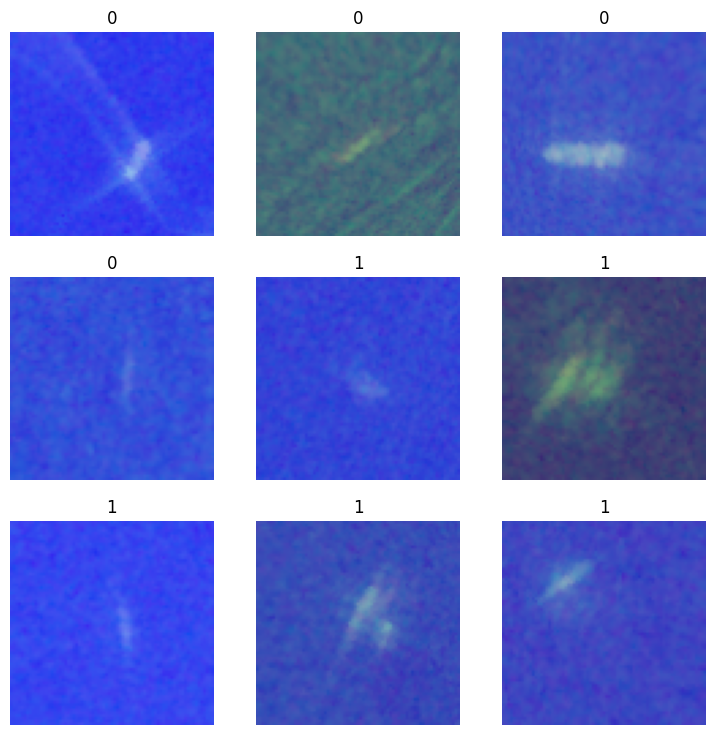

In [10]:
dls.show_batch()

Ser bra ut!

## Lære modellen
Vi bruker cnn-learner og resnet50. resnet50 ble brukt mot slutten ettersom den tar lenger tid å produsere.

In [11]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,time
0,1.245565,1.007976,0.662500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.919685,0.698040,0.721875,00:09
1,0.773342,0.583026,0.753125,00:09
2,0.665027,0.617998,0.731250,00:07
3,0.596191,0.387868,0.809375,00:07
4,0.523034,0.340529,0.853125,00:07
5,0.473390,0.318006,0.846875,00:07
6,0.441576,0.305421,0.881250,00:08
7,0.399519,0.310187,0.843750,00:06
8,0.369634,0.310686,0.868750,00:07
9,0.349759,0.311386,0.868750,00:05


Vi får en modell som gir et resultat på prosent 89 %. For å få en bedre forståselse for hvor bra dette er sammenlinget med hvordan andre har gjort det i kaggle konkuransen.

Ser på et eksempel.

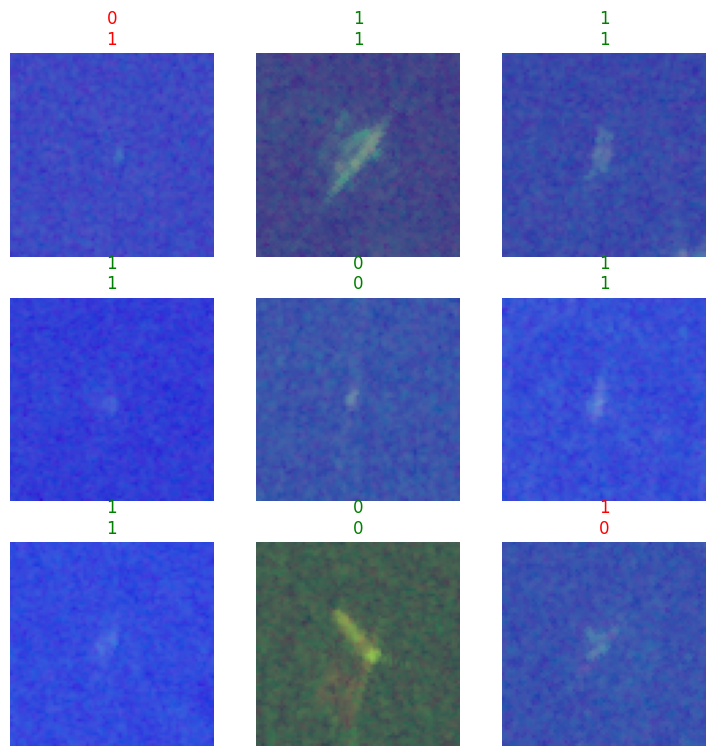

In [13]:
learn.show_results()

## Konkuranse
Bruker test dataen

In [14]:
test = pd.read_json(r"/content/drive/MyDrive/Iceberg challenge/test.json")
test.head()

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.172482, -15.443275, -14.011121, -16.124729, -17.779478, -19.42761, -18.219221, -17.463379, -20.242298, -17.672544, -16.394279, -16.672922, -15.948608, -17.058884, -14.292757, -11.704641, -12.661265, -16.863401, -15.360503, -14.292401, -14.58432, -16.960165, -18.681437, -16.578163, -15.861324, -15.360004, -15.690865, -17.359159, -19.42597, -17.257425, -14.809227, -15.606586, -16.484625, -16.484625, -17.057457, -15.119185, -15.946968, -17.994354, -17.057173, -17.156368, -14.582966, -12.367072, -12.600193, -12.600121, -14.29069, -14.884757, -15.68951, ...","[-21.629612, -21.142353, -23.908337, -28.34524, -27.006233, -25.846321, -22.507294, -23.080124, -23.907907, -24.585001, -23.07991, -23.079838, -22.506865, -22.693594, -25.067318, -25.319031, -27.005375, -23.692787, -23.279026, -24.35265, -23.483265, -23.483192, -23.079054, -22.144115, -22.506008, -23.278524, -22.883572, -23.906551, -20.679121, -21.796206, -25.317959, -29.099014, -27.32012, -25.844324, -24.583218, -25.5769, -25.5769, -26.119877, -24.583004, -25.065605, -23.077843, -22.504868, -24.351082, -25.576403, -25.843611, -25.065178, -24.350796, -26.119164, -25.576048, -22.882004, -21...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26.058969497680664, -22.74645233154297, -22.74645233154297, -22.33283805847168, -21.747129440307617, -21.747129440307617, -25.175128936767578, -21.377613067626953, -21.560558319091797, -24.121231079101562, -23.876619338989258, -28.558361053466797, -23.876811981201172, -24.899940490722656, -23.876930236816406, -23.639020919799805, -24.373554229736328, -20.851806640625, -26.376052856445312, -23.87735366821289, -22.134428024291992, -24.373979568481445, -24.373979568481445, -24.900636672973633, -23.639677047729492, -25.46136474609375, -25.75590515136...","[-25.754207611083984, -25.754207611083984, -25.754207611083984, -21.747013092041016, -21.747013092041016, -23.63821029663086, -26.37504768371582, -26.37504768371582, -20.516881942749023, -21.7473201751709, -22.746877670288086, -24.12126922607422, -27.398483276367188, -26.05962562561035, -22.747222900390625, -24.899940490722656, -22.74734115600586, -25.75513458251953, -21.748016357421875, -21.561290740966797, -26.703895568847656, -22.747764587402344, -22.747840881347656, -25.75563621520996, -25.75563621520996, -24.374095916748047, -25.176517486572266, -26.704360961914062, -25.17667388916015...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17.375520706176758, -15.738972663879395, -19.00137710571289, -18.0351619720459, -13.853211402893066, -9.806072235107422, -12.12912654876709, -18.034561157226562, -16.46988296508789, -16.960622787475586, -18.034198760986328, -13.781915664672852, -13.108133316040039, -16.859724044799805, -18.033716201782227, -14.588298797607422, -18.62458038330078, -12.017221450805664, -13.646560668945312, -16.191293716430664, -13.374862670898438, -12.856027603149414, -15.147371292114258, -18.152143478393555, -16.568397521972656, -13.30757999420166, -14.668523788452...","[-14.74563980102539, -14.590410232543945, -14.36269760131836, -16.56688690185547, -18.8746337890625, -20.382936477661133, -16.005950927734375, -11.354377746582031, -11.957183837890625, -14.213252067565918, -14.822917938232422, -16.28099250793457, -17.92071533203125, -14.06678581237793, -13.173256874084473, -14.66580867767334, -18.873065948486328, -16.280269622802734, -15.737103462219238, -18.033414840698242, -12.074493408203125, -14.364751815795898, -15.397045135498047, -12.66928768157959, -15.065874099731445, -15.828906059265137, -17.48360824584961, -12.247831344604492, -14.06931972503662...",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674, -13.572674, -13.057875, -13.120657, -14.191113, -12.811657, -16.833597, -15.918447, -16.005814, -22.854336, -21.270781, -20.501686, -20.501686, -17.966253, -13.376769, -12.112302, -14.408065, -15.012615, -13.507596, -15.331469, -15.66246

Lager en dataloader basert på testdataen.

In [15]:
test_dl = dls.test_dl(test)

Predicter dataen.

In [16]:
predictions, _ = learn.get_preds(dl=test_dl)

Predictionen kommer ut som en tensor. Tensoren inneholder tall som sier noe som hva modellen tror det er.

In [17]:
predictions

tensor([[9.1146e-01, 8.8540e-02],
        [9.6440e-01, 3.5598e-02],
        [9.9991e-01, 9.4304e-05],
        ...,
        [9.9226e-01, 7.7355e-03],
        [4.9498e-04, 9.9951e-01],
        [9.8041e-01, 1.9589e-02]])

Det de er ute etter er hvor sansynelig det er at det er et isfjell. Brukes andre kollonne

In [22]:
predicted_labels = [float(i) for i in predictions[:, 1]]

Lagrer resultatet

In [23]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': predicted_labels})
submission.to_csv('submission.csv', index=False)

Får et resultat på 0.25067, noe som er et lite stykke fra vinneren med 0.08227, men sammenlignbart.